# Load Tools

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import docx
import PyPDF2
import spacy

In [ ]:
nlp = spacy.load("en_core_web_sm")

# Extracting the Content from the Resume

In [ ]:
def extract_text_from_docx(docx_file):
    doc = docx.Document(docx_file)
    return '\n'.join([para.text for para in doc.paragraphs])

def extract_text_from_pdf(pdf_file):
    pdf_reader = PyPDF2.PdfReader(pdf_file)
    text = ''
    for page_num in range(len(pdf_reader.pages)):
        text += pdf_reader.pages[page_num].extract_text()
    return text

def extract_resume_info(text):
    id_pattern = r"\bID[:\s]*(\d+)\b"
    applicant_id = re.search(id_pattern, text)
    applicant_id = applicant_id.group(1) if applicant_id else "ID not found"

    job_category_pattern = r"\b(Job Category|Position|Title)[:\s]*([\w\s]+)\b"
    job_category = re.search(job_category_pattern, text)
    job_category = job_category.group(2).strip() if job_category else "Job category not found"

    doc = nlp(text)
    features = {
        "Skills": [],
        "Education": [],
        "Experience": []
    }

    for ent in doc.ents:
        if ent.label_ == "SKILL":
            features["Skills"].append(ent.text)
        elif ent.label_ in ["EDUCATION", "DEGREE"]:
            features["Education"].append(ent.text)
        elif ent.label_ in ["WORK_EXPERIENCE", "DATE", "DURATION"]:
            features["Experience"].append(ent.text)

    return applicant_id, job_category, features

def extract_resume_keywords(file_path):
    file_extension = os.path.splitext(file_path)[1].lower()

    if file_extension == '.docx':
        text = extract_text_from_docx(file_path)
    elif file_extension == '.pdf':
        text = extract_text_from_pdf(file_path)
    else:
        raise ValueError("Unsupported file format. Please use DOCX or PDF.")

    keywords = extract_resume_info(text)
    return keywords


In [ ]:
clean_df = pd.read_csv("clean_resume_data.csv")

# Export the Clean Dataset

In [ ]:
clean_df

,ID,Category,Feature
0,16852973,HR,hr administrator marketing associate hr admini...
1,22323967,HR,hr specialist hr operations summary media prof...
2,33176873,HR,hr director summary years experience recruitin...
3,27018550,HR,hr specialist summary dedicated driven dynamic...
4,17812897,HR,hr manager skill highlights hr skills hr depar...
...,...,...,...
2479,99416532,AVIATION,rank sgt e non commissioned officer charge bri...
2480,24589765,AVIATION,government relations communications organizati...
2481,31605080,AVIATION,geek squad agent professional profile support ...
2482,21190805,AVIATION,program director office manager summary highly...


In [ ]:
clean_df['Category'].value_counts()

,count
Category,
INFORMATION-TECHNOLOGY,120
BUSINESS-DEVELOPMENT,120
FINANCE,118
ADVOCATE,118
ACCOUNTANT,118
ENGINEERING,118
CHEF,118
AVIATION,117
FITNESS,117


In [ ]:
clean_df.to_csv('clean_resume_data.csv')

In [ ]:
clean_df.shape

(2484, 3)

# Exploratory Data analysis

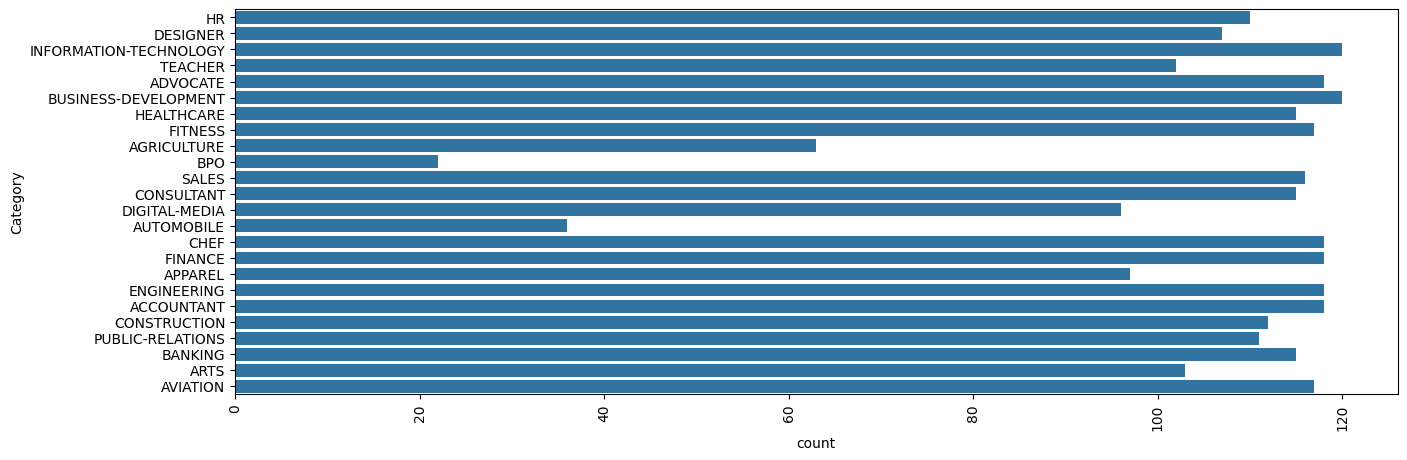

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(clean_df['Category'])
plt.xticks(rotation=90)
plt.show()

# Balance Dataset

In [ ]:
from sklearn.utils import resample
max_count = clean_df['Category'].value_counts().max()

balanced_data = []
for category in clean_df['Category'].unique():
    category_data = clean_df[clean_df['Category'] == category]
    if len(category_data) < max_count:
        balanced_category_data = resample(category_data, replace=True, n_samples=max_count, random_state=42)
    else:
        balanced_category_data = resample(category_data, replace=False, n_samples=max_count, random_state=42)
    balanced_data.append(balanced_category_data)

balanced_df = pd.concat(balanced_data)

In [ ]:
balanced_df.dropna(inplace=True)

# Train-Test Split


In [ ]:
X = balanced_df['Feature']
y = balanced_df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encoding (TF-IDF)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#  Train Random Forest Classifier

Accuracy: 0.8489583333333334
                        precision    recall  f1-score   support

            ACCOUNTANT       0.77      0.95      0.85        21
              ADVOCATE       1.00      0.79      0.88        29
           AGRICULTURE       0.90      0.78      0.84        23
               APPAREL       0.94      0.81      0.87        21
                  ARTS       0.88      0.64      0.74        22
            AUTOMOBILE       0.95      1.00      0.97        19
              AVIATION       0.94      1.00      0.97        30
               BANKING       1.00      0.78      0.88        23
                   BPO       1.00      1.00      1.00        15
  BUSINESS-DEVELOPMENT       0.56      0.78      0.65        18
                  CHEF       0.90      1.00      0.95        28
          CONSTRUCTION       0.86      1.00      0.93        25
            CONSULTANT       0.94      0.55      0.69        31
              DESIGNER       0.96      0.96      0.96        28
         D

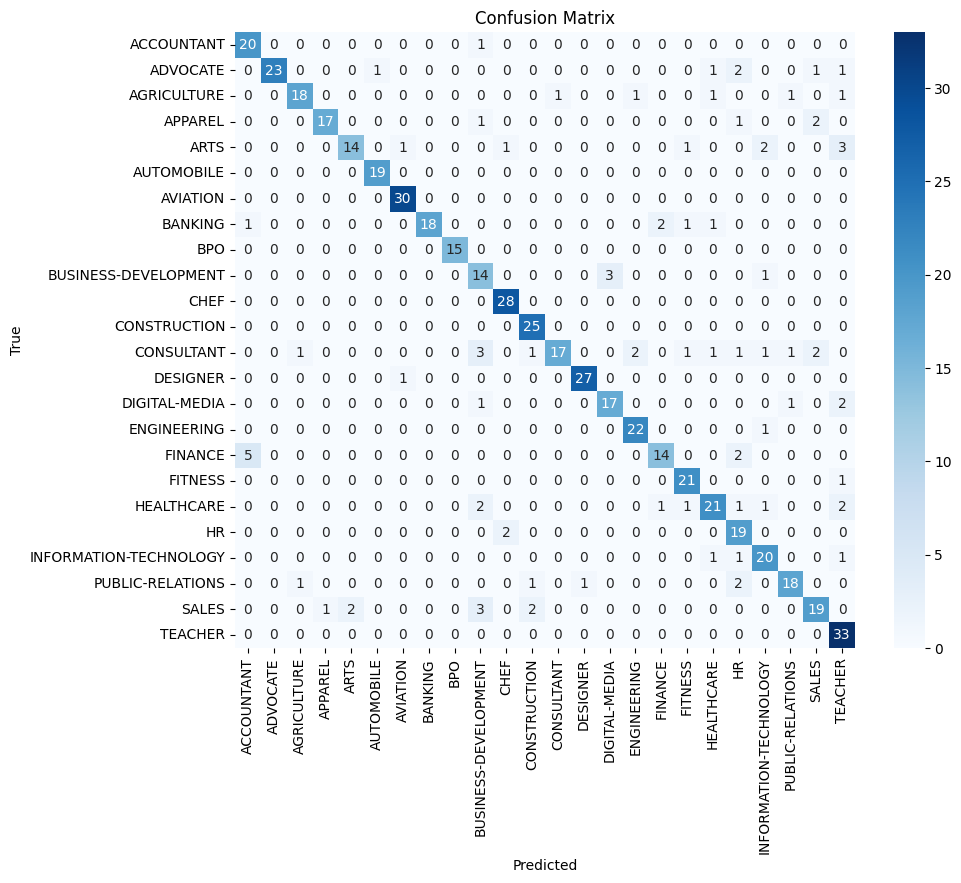

In [ ]:
from sklearn.metrics import classification_report

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_tfidf, y_train)

y_pred = rf_classifier.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test,y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Predictive System

In [ ]:
def predict_category(resume_text):
    resume_text= cleanResume(resume_text)
    resume_tfidf = tfidf_vectorizer.transform([resume_text])
    predicted_category = rf_classifier.predict(resume_tfidf)[0]
    print("**Predicted Category: "+predicted_category+"**")
    print()


In [ ]:
# Example Usage
resume_file = """hr assistant summary hard worker dedicated detailed oriented experienced organized highly motivated many attributes possess individual years experience human resource administration customer service talent quickly adapt new challenges experience focused benefits administration payroll career development employment law highlights assigned administrative assignments daily basis implemented employee handbook processed documentation employees conducted employees performance reviews managed employee scheduling coordinated upper level co worker lower level teamwork oriented processed new recruits processed payroll performed check managed inventory supplies secured new wholesale food purveyor decrease costs increase profits accomplishments accomplishments pho n restaurant managed restaurant financial objectives developing financing establishing banking relationships prepared strategic annual forecasts budgets analyzing variances initiating corrective actions establishing financial controls developed implemented strategies increase average meal checks created restaurant business plan surveying restaurant demand conferring people community identifying evaluating competitors preparing financial marketing sales projections analyses estimates controlled purchases inventory meeting account manager negotiating prices contracts developing preferred supplier lists reviewing evaluating usage reports analyzing variances taking corrective actions contributed team effort inspired team members motivation provided high level customer service maintain high profile day day operations handled complaints contentious issues settled directly team members provides fast solution accomplished campaign recycle program divide right trash right bin accomplishments dr norman g mckoy associates demonstrated success administrative employee handbook developing team building programs corporate policies job descriptions management reports organized office documents patients charts organized office woking areas welcomed new employees organization conducting orientation organized employees document pockets maintained employees confidence protect operation keeping human resource information confidential maintained employee information entering updating employment status change data provided payroll information collecting time attendance records provided secretarial support entering formatting printing information organizing work answering telephone relaying messages maintaining equipment supplies experience company name city state hr assistant increased productivity physician office organizing patients charts converting digital files streamline patient maintenance processed pay roll paychex includes ensured vacation sick time tracked system answered payroll questions facilited resolutions payroll errors processed incoming mails going mails successfully edited employee handbook define job descriptions create office policies patient managing proper patient reports wrote employee handbook covering issues including disciplinary procedures code conduct fmla policy benefits information wrote standard operations procedures manual sops detailed aspect employee expectations designed implement overall recruiting strategy coordinated office manager recruit right candidates administering interviews conducting background checks processed documentation prepared reports relating personnel activities staffing recruitment training performance evaluations etc identified reduced business expenses increase profits controlling budget compares actual results budget expectations company name city state general manager current hostess waitress promoted interview recruit new hires order sustain longer hours operation thus increased company profitswas successful ensuring successful integration new hires implementing training compensation structures ordered foods supplies restaurant checked maintained inventory handling daily accounting processing payroll processed cost reduction thought venders whole sale increased marketability restaurant designing creating new modernized menu prepared willing step restaurant short staff low turn order increase productivity provide best service maintained great quality quantity foods restaurant created recycle program divided recyclable bin non recyclable waste bin education bachelor arts humanities english university thai chamber commerce city thailand humanities english excelled language culture transportation management critical reading article writing advanced technical reading master science human resource management strayer university city state usa human resource management magna cum laude excelled human resources law management ethical hr information systems hris strategic management registered professional human resources aphr certification hr designations registering aphr professional human resources exam expect complete aphr certification professional affiliations enrolling ongoing training areas compensation benefits employee labor relations leaves absence workers compensation workplace safety security member society human resource management shrm skills human resource management skills employment law hr policies procedures training development performance management employee relations mediation benefits administration orientation boarding organizational development staff life cycle computer skills hris applications peoplesoft enterprise human resources ms office word excel powerpoint access outlook e mailing tools ms outlook windows outlook yahoo google networking skills job boards networking sites soft skills professional communication skills interpersonal skills bilingual thai english excellent adaptability new environments hard working flexible reliable honest polite shape decision making excellent customer service skills creative
"""

predicted_category = predict_category(resume_file)
print("Predicted Category:", predicted_category)

Predicted Category: HR


In [ ]:
# Example Usage
resume_file='information technology manager network engineer professional overview highly skilled accomplished information technology manager years expertise planning implementing streamlining systems ensure maximum customer satisfaction business revenue strong leader demonstrated ability work effectively individuals levels functional areas exceptional communication project management skills ability successfully manage multiple priorities assignments skills platforms windows server professional windows xp pro home win dos citrix ica ms exchange hardware hp ibm dell intel based server desktop platforms cisco switches sonic wall hardware vpns hp laser jets toshiba e color copier toshiba sony laptops inter tel software ms office visio citrix metaframe xp symantec pc anywhere ghost antivirus utilities win fax mcafee virus scan adobe acrobat illustrator photoshop partition magic adware spyware networking tcp ip wireless b g dns wins dhcp relevant experience information technology manager network engineer feb current company name city state responsible day day operations functions wilkes six offices staff members currently lead team professionals developers planning upgrades implementation systems business applications development new software tools work closely cio senior management ensure business technology objectives aligned researched new technologies calculated future needs achieve accurate capacity planning negotiated hardware software purchases maintenance contracts dramatically reduced costs maintenance virtualizing company infrastructure using vmware reduced physical servers streamlined disaster recovery processes planned executed active directory domain migration r coordinated planning migration mpls network sites including upgrades routers switches network equipment increased speed reliability company email migrating microsoft exchange streamlined operations designing new citrix infrastructure using netscaler load balancers ensure better speed connectivity less downtime remote offices led planning implementation disaster recovery site atlanta created company first comprehensive business continuity plan tested success installed configuring barracuda spam virus firewalls resulting reduction spam enforced security policies managed monitored updated spam filtering virus malware prevention systems reduced desktop application deployment times designing implementing microsoft system center configuration manager conducted training internal systems local procedures technical subjects company employees coordinate external technology vendors internal staff members third party consultants network engineer sep jan company name city state administered managed windows server network environment responsible lan wan duties local remote networks acted technical consultant clients various projects provide end user support windows xp operating systems installed implemented exchange mail server implemented server desktop security using mcafee enterprise epolicy orchestrator installed configured web servers ftp servers pop mail servers manage cisco switches routers configured vpn remote access users implemented software domain policies patches upgrades using group policy sus trained new employees systems administration web development network support technician jan aug company name city provided network desktop support users provided technical support offices b domain supported help desk using help star software troubleshooting windows desktop computers implemented group policy objects control desktop environment security performed hardware software upgrades replacements performed installations troubleshooting ms office suite managed users computers organizational units active directory created disc images desktop notebook computers using norton ghost troubleshooting repairs laser printers copy machines education bachelor science management information systems university maryland university college city state certifications microsoft certified technology specialist mcts citrix certified administrator cca information systems management certificate project management certificate'

predicted_category = predict_category(resume_file)
print("Predicted Category:", predicted_category)

Predicted Category: INFORMATION-TECHNOLOGY


In [ ]:
# Example Usage
resume_file = """Objective:
A creative and detail-oriented Designer with a passion for visual communication and brand identity seeking opportunities to leverage design skills in a dynamic and collaborative environment.

Education:
- Bachelor of Fine Arts in Graphic Design, XYZ College, GPA: 3.7/4.0
- Diploma in Web Design, ABC Institute, GPA: 3.9/4.0

Skills:
- Proficient in Adobe Creative Suite (Photoshop, Illustrator, InDesign)
- Strong understanding of typography, layout, and color theory
- Experience in both print and digital design
- Ability to conceptualize and execute design projects from concept to completion
- Excellent attention to detail and time management skills

Experience:
Graphic Designer | XYZ Design Studio
- Created visually appealing graphics for various marketing materials, including brochures, flyers, and social media posts
- Collaborated with clients to understand their design needs and deliver creative solutions that align with their brand identity
- Worked closely with the marketing team to ensure consistency in brand messaging across all platforms

Freelance Designer
- Designed logos, branding materials, and website layouts for small businesses and startups
- Managed multiple projects simultaneously while meeting tight deadlines and maintaining quality standards
- Established and maintained strong client relationships through clear communication and exceptional service

Projects:
- Rebranding Campaign for XYZ Company: Led a team to redesign the company's logo, website, and marketing collateral, resulting in a 30% increase in brand recognition
- Packaging Design for ABC Product Launch: Developed eye-catching packaging designs for a new product line, contributing to a successful launch and positive customer feedback

Certifications:
- Adobe Certified Expert (ACE) in Adobe Illustrator
- Responsive Web Design Certification from Udemy

Languages:
- English (Native)
- Spanish (Intermediate)
"""
predicted_category = predict_category(resume_file)
print("Predicted Category:", predicted_category)

Predicted Category: DESIGNER


# Skill Recommendation

In [ ]:
# !pip install google-cloud-aiplatform

In [ ]:
import google.generativeai as genai
import os

In [ ]:
import os
from google.cloud import aiplatform

os.environ['GOOGLE_API_KEY'] = "GOOGLE API KEY"
genai.configure(api_key=os.environ['GOOGLE_API_KEY'])

In [ ]:
def generate_skill_recommendation_prompt(resume_text, pred_job):
    prompt = f"""
    Given the following resume, extract the key skills mentioned, and recommend
    additional skills that could be valuable based on the person's experience.
    Provide the recommendation in the form of a list.

    Resume:
    {resume_text}

    For the job of: {pred_job}

    Skills:
    """
    return prompt


In [ ]:
def get_skill_recommendation(prompt, job):

    prompt = generate_skill_recommendation_prompt(resume_text, job)
    model=genai.GenerativeModel("gemini-pro")
    response=model.generate_content(prompt)
    return response.text

# User Interface Module

In [ ]:
# %pip install pdfplumber

In [ ]:
import pdfplumber

In [ ]:
def extract_text_from_pdf(pdf_path):
    text = ''
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text()
    return text

In [ ]:
from google.colab import files

uploaded = files.upload()
for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')

Saving designer.pdf to designer (1).pdf
Uploaded file: designer (1).pdf


In [ ]:
pdf_path = list(uploaded.keys())[0]
resume_text = extract_text_from_pdf(pdf_path)
print(resume_text)

Objective:
A creative and detail-
oriented Designer with a passion for visual communication and brand identity seeking
opportunities to leverage design skills in a dynamic and collaborative environment.
Education:
- Bachelor of Fine Arts in Graphic Design, XYZ College, GPA: 3.7/4.0
- Diploma in Web Design, ABC Institute, GPA: 3.9/4.0
Skills:
- Proficient in Adobe Creative Suite (Photoshop, Illustrator, InDesign)
- Strong understanding of typography, layout, and color theory
- Experience in both print and digital design
- Ability to conceptualize and execute design projects from concept to completion
- Excellent attention to detail and time management skills
Experience:
Graphic Designer | XYZ Design Studio
- Created visually appealing graphics for various marketing materials, including broc
hures, flyers, and social media posts
- Collaborated with clients to understand their design needs and deliver creative sol
utions that align with their brand identity
- Worked closely with the marke

In [ ]:
pred_job = predict_category(resume_text)
skill_recommendations = get_skill_recommendation(resume_text, pred_job)
print(skill_recommendations)

**Predicted Category: DESIGNER**

**Key Skills:**

- Adobe Creative Suite (Photoshop, Illustrator, InDesign)
- Typography and layout
- Color theory and branding principles
- Print and digital design experience
- Concept development and execution
- Attention to detail and time management
- Client collaboration
- Communication skills

**Recommended Additional Skills:**

- User experience (UX) design
- User interface (UI) design
- Motion graphics
- 3D modeling
- Content strategy
- Digital marketing
- Search engine optimization (SEO)
- Social media marketing
